The Mesh
======

The mesh is the base construct for an Underworld model. It provides support for the discrete variables we wish to solve for, or that are used to define the model. This notebook will go through a few different examples of what can be done with meshes within Underworld. 

**This notebook is broken down into the following examples:**

1. Overview of meshes.
2. Setting and visualising up meshes.
3. How to modify a mesh.
4. Loading and saving meshes.
5. Different mesh geometry types.

**Keywords:** meshes, mesh geometry

**References**

1. Moresi, L., Dufour, F., Muhlhaus, H.B., 2002. Mantle convection modeling with viscoelastic/brittle lithosphere: Numerical methodology and plate tectonic modeling. Pure Appl. Geophys. 159 (10), 2335–2356.
2. Moresi, L., Dufour, F., Muhlhaus, H.B., 2003. A Lagrangian integration point finite element method for large deformation modeling of viscoelastic geomaterials. J. Comput. Phys. 184, 476–497.
3. Moresi, L., Quenette, S., Lemiale, V., Meriaux, C., Appelbe, B., Muhlhaus, H.-B., 2007. Computational approaches to studying non-linear dynamics of the crust and mantle. Physics of the Earth and Planetary Interiors 163, 69–82.


In [1]:
import underworld as uw
import glucifer

Mesh overview
------

Underworld uses a modified finite element method which uses both a fixed background computational mesh and a collection of Lagrangian tracking points. The details of the implementation of the method are given in Moresi et al. (2002, 2003) and a summary of the approach taken by the Underworld code is given in Moresi et al. 2007.




Setting up meshes
-----

**Create a mesh object**

Within Underworld we usually solve the Stokes flow problem. This requires meshes for both the velocity and pressure.
Generally, the pressure and velocity meshes have a certain relationship with each other for numerical stability.
Hence we have a mesh object for the velocity and a so-called sub mesh for the pressure that is tied to the velocity mesh.

If we have a temperature field then this also requires a mesh. We usually make this mesh the same as the velocity mesh.

Underworld has a number of different mesh types:
  * Q2: quadratic mesh
  * Q1: linear mesh
  * dP1c: discontinuous linear mesh.
  * dQ0: discontinuous constant mesh. (i.e. 1 node in the centre of the element)

Only the following combinations of velocity/pressure mixed elements are used in Underworld:
  * Q2/dP1c
  * Q2/Q1
  * Q1/dQ0

A visualisation of a mixed mesh element node using the "Q1/dQ0" types is shown below in 2D and 3D.
![](Figures/Mesh_Q1dQ0.png)
Also see [here](http://femtable.org/) for a full list of element types and their naming conventions.

Let us now create a 2D mesh object with minimum cordinates (0.0, 0.0), maximum coordinates of (1.0, 1.0) and a resolution of $4 \times 4$ cells (for 3D simply add an extra term in the tuples for the ``elementRes``, ``minCoord`` and ``maxCoord``).

In [2]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dpc1"), 
                                 elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (2., 1.))

**Plot representation of mesh**

To see what the mesh looks like we plot it using the ``.Mesh`` function in ``gLucifer``.


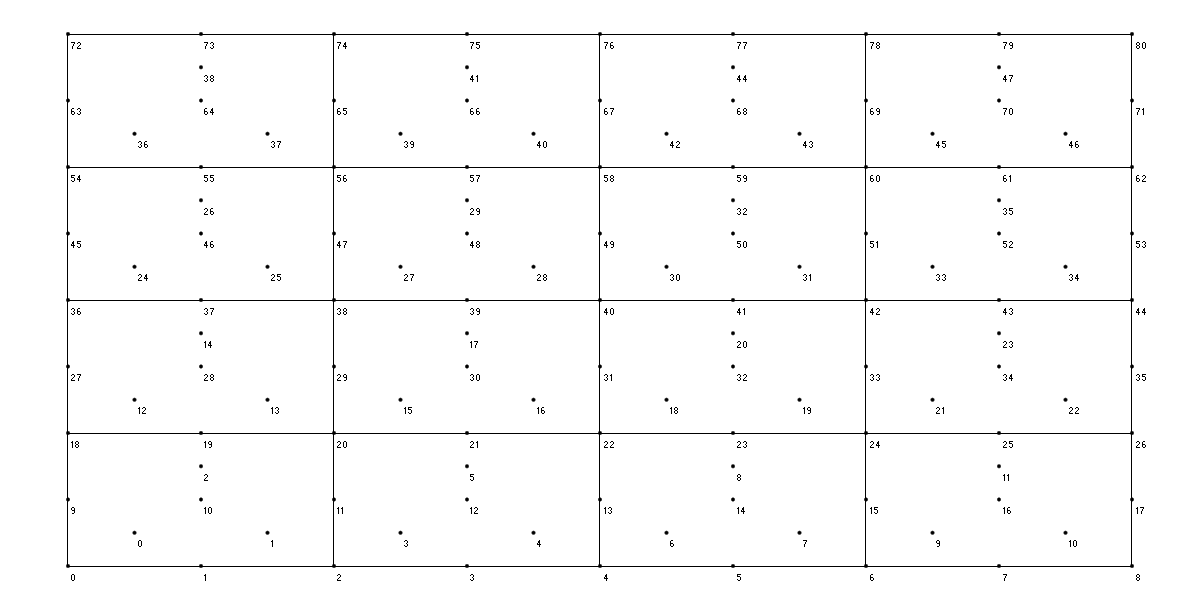

In [3]:
figMesh = glucifer.Figure(figsize=(1200,600))
figMesh.append( glucifer.objects.Mesh(mesh.subMesh, nodeNumbers=True) )
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=True) )
figMesh.show()

**Sub meshes**

The list of spatial coordinates for each mesh node is stored in the ``.data`` method of the mesh or sub mesh object. 

Due to their different configurations, the total number of mesh points for the mesh and sub mesh are different. This can be demonstrated by looking at the lengths of the coordinate data arrays.

In [4]:
print(' Number of mesh points (Total) = {0:2d}'.format(len(mesh.data)))
print('      Number of submesh points = {0:2d}'.format(len(mesh.subMesh.data)))

 Number of mesh points (Total) = 81
      Number of submesh points = 48


In the above figure the large points are on the vertex node points for the ``elementMesh`` grid, while the smaller points denote the ``subMesh``. The larger mesh is used for the velocity field, while the pressure field is represented on the sub mesh.

Modifying meshes
-----

Underworld allows for simple modification of existing meshes. For example, the following commands create a mesh which is exponentially spaced in the vertical direction, thus increasing the resolution at the top of the simulation domain.


In [5]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (8, 8), 
                                 minCoord    = (0.0, 0.0), 
                                 maxCoord    = (2.0, 1.0),
                                 partitioned = False )

**Note:** the mesh above has been defined to be not partitioned. When running ``underworld`` in parallel this means that all processors have access to the entire mesh, rather than a locally partitioned subset of the mesh. Adding this here means that deforming a particular mesh node below will work in parallel. 


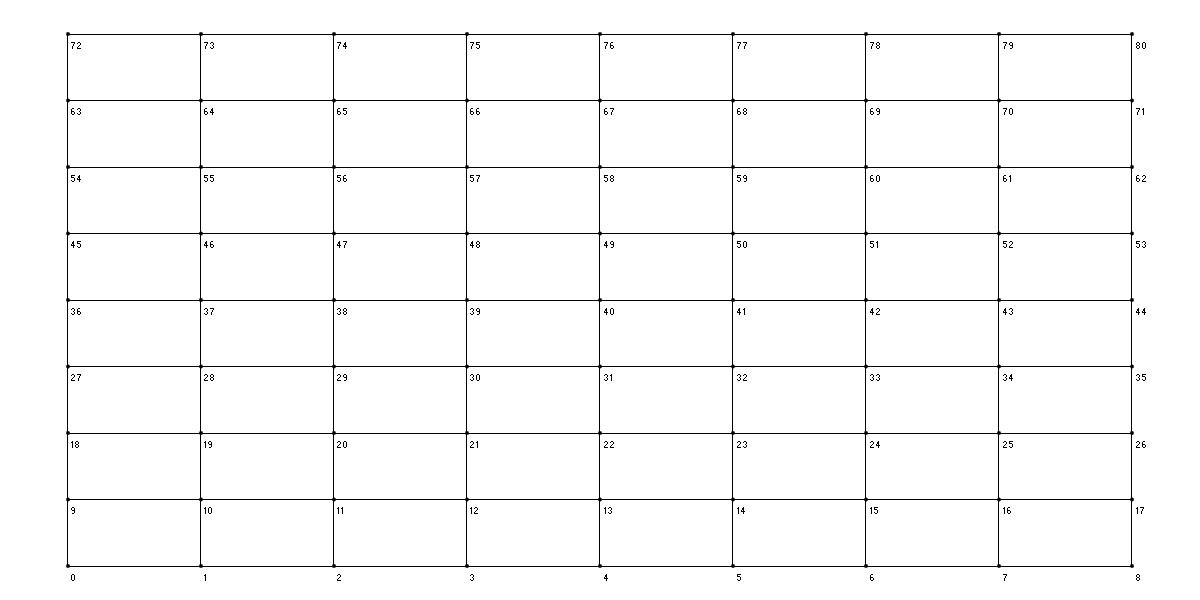

In [6]:
figMesh = glucifer.Figure(figsize=(1200,600))
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=True) )
figMesh.show()

By default the mesh data is read only. The following cell will unlock the mesh and displace a single node of the mesh in the positive x direction.


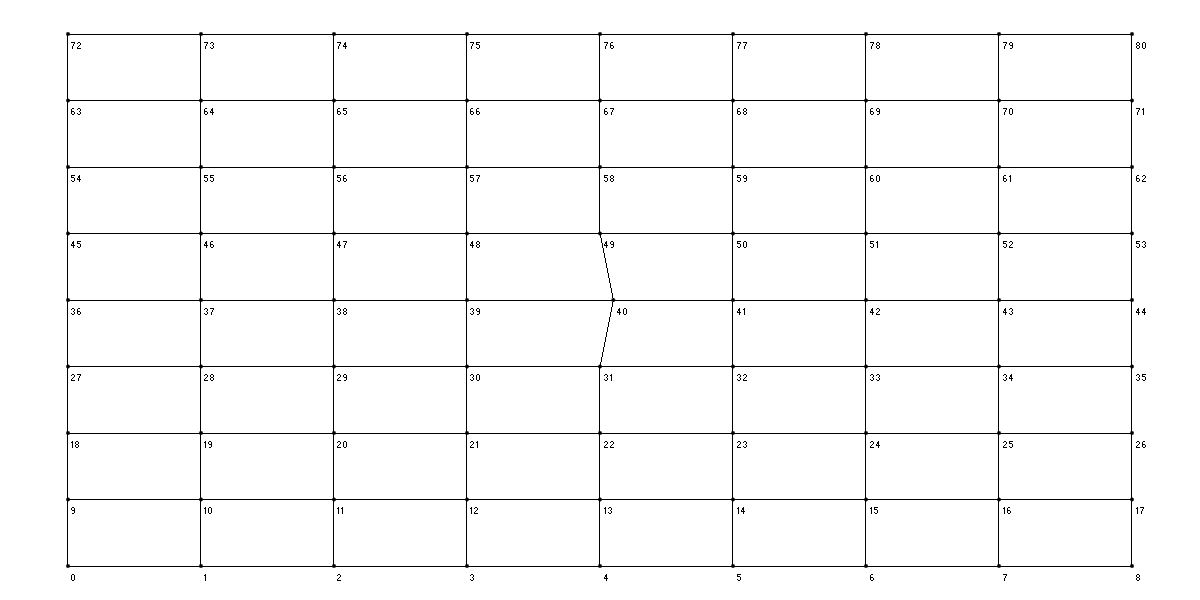

In [7]:
with mesh.deform_mesh():
    mesh.data[40][0] += 0.025
figMesh.show()

Deforming meshes allows us to increase resolution where it is needed most. For example at the top of the simulation domain by redefining the vertical mesh coordinate to be $z := 1-z^2$ 


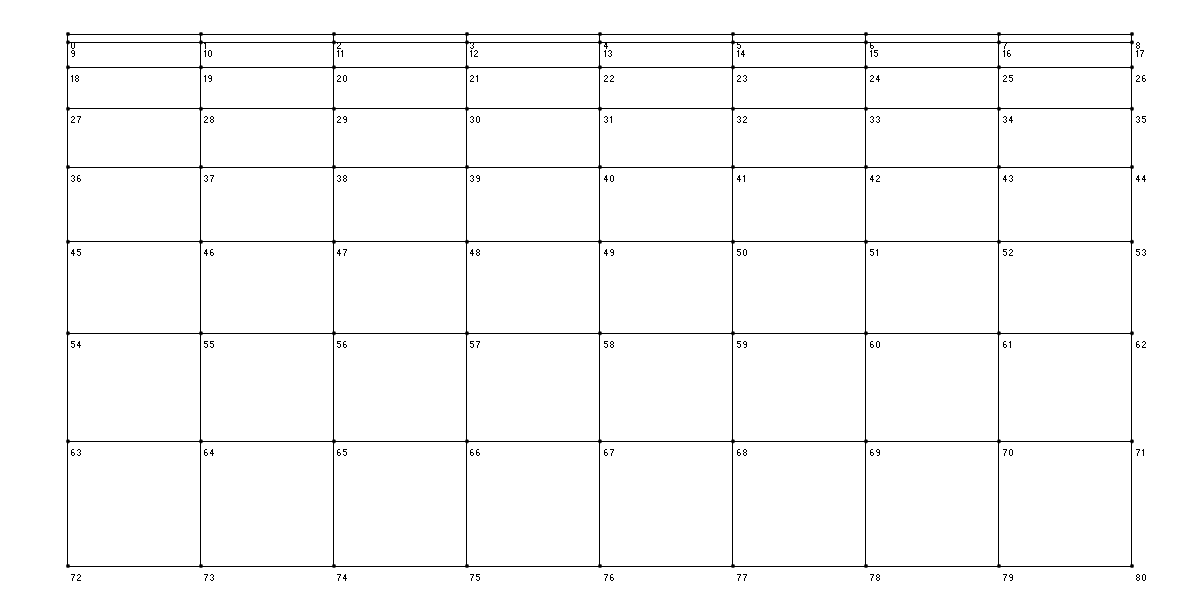

In [8]:
mesh.reset()  # restore the mesh to the original configuration specified by elementType
with mesh.deform_mesh():
    for index, coord in enumerate(mesh.data):
        mesh.data[index][1] = 1.0 - mesh.data[index][1]*mesh.data[index][1]
figMesh.show()

Saving and loading meshes
------

Mesh coordinate data can be saved in hdf5 format using the ``save`` method attached to the ``mesh`` class. The following line will save the mesh to a file.

In [9]:
mesh.save('deformedMesh.h5')

To check that this has worked we will re-create the mesh, plot and then reload the saved mesh.


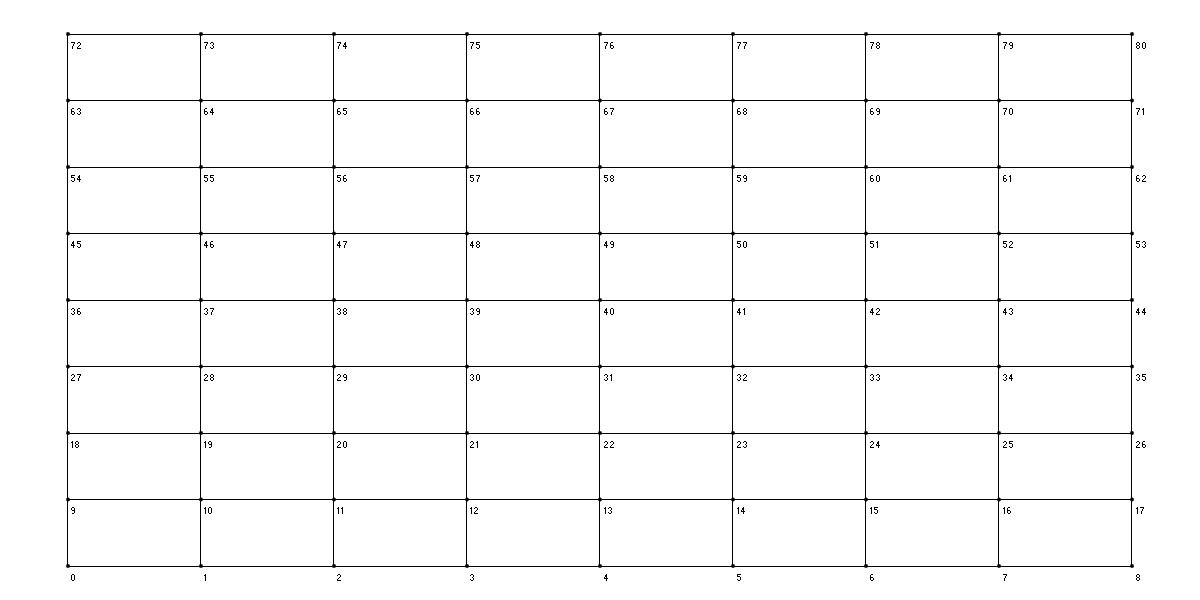

In [10]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (8, 8), 
                                 minCoord    = (0.0, 0.0), 
                                 maxCoord    = (2.0, 1.0))
figMesh = glucifer.Figure(figsize=(1200,600))
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=True) )
figMesh.show()

Now load the mesh and display:


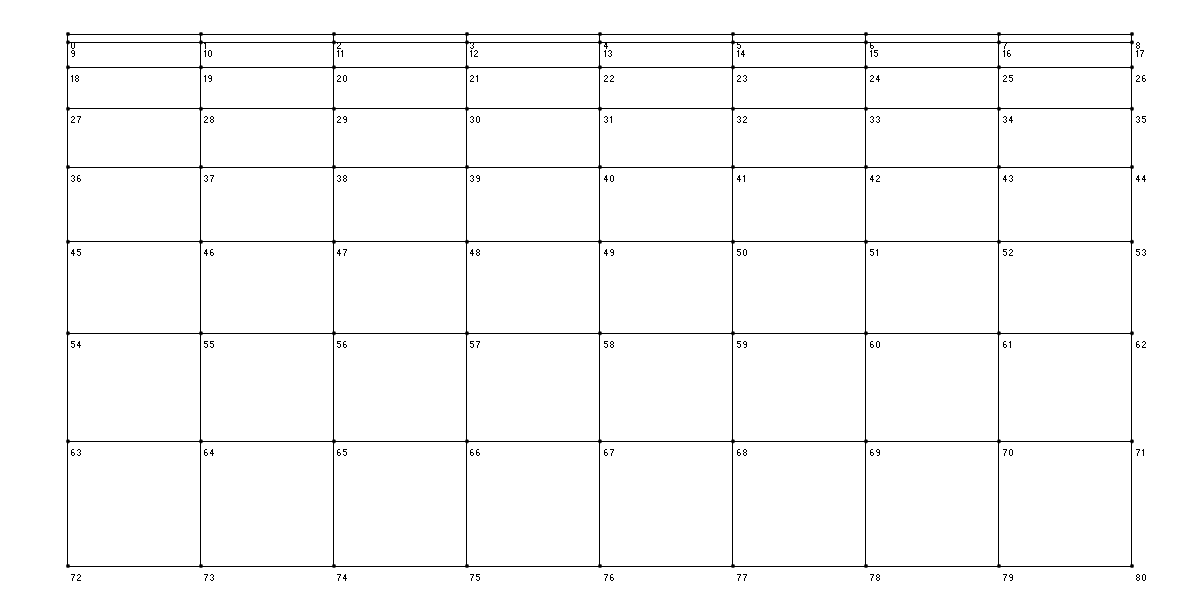

In [11]:
mesh.load('deformedMesh.h5')
figMesh.show()